<h1 align="center">
  <a href="https://uptrain.ai">
    <img width="300" src="https://user-images.githubusercontent.com/108270398/214240695-4f958b76-c993-4ddd-8de6-8668f4d0da84.png" alt="uptrain">
  </a>
</h1>

<h1 style="text-align: center;">Performance Comparison of Reinforcement Learning Agents</h1>

**Overview**: When we train Reinforcement Learning (RL) agents to perform tasks, we need to compare the performance of different agents to see which one performs better. But how can we do that? In this case, we'll explore different evaluation metrics and visualization techniques to compare RL agents. We'll focus on metrics like the average reward achieved during training, the speed of learning, and the stability of the learning process. We'll also use different types of plots, such as learning curves, to help us compare the agents more easily.

**Problem**: When we're trying to compare different RL agents, it can be tough to figure out which one is best. Each agent may perform well on certain tasks or in certain environments, but not so well in others. It's hard to know which agent will perform the best in the specific task we care about. Additionally, the agents can take a long time to train, and it's tough to know if we've given them enough time to really learn how to solve the task. Finally, even if we have a good idea of which agent is the best, it's hard to be confident in our answer. We need some way to know if the difference in performance between the agents is due to chance, or if it's a real difference that we can trust.

**Solution**: To compare reinforcement learning agents, we need to use a set of standardized tests that cover a range of tasks and environments. By using the same tests for all agents, we can compare their performance in a way that's fair and meaningful. We need to track the agents' progress over time, giving them enough time to learn but not too much, and then analyze the results using statistical techniques to make sure we can trust our conclusions. By tracking progress and using statistical techniques, we can compare the agents in a fair and reliable way that helps us choose the best one for our needs.

### Installing and Importing Required Libraries

In this example, we will be using the following libraries:
- [OpenAI Gym](https://gymnasium.farama.org/): for accessing reinforcement learning environments
- [Numpy](https://numpy.org/)
- [Torch](https://pytorch.org/) for creating neural networks and agents
- [UpTrain](https://github.com/uptrain-ai/uptrain) for tracking model performance

In [1]:
!pip3 install gymnasium[all] numpy torch uptrain

In [ ]:
import gymnasium as gym
import numpy as np
import torch
import uptrain

from deep_q_network import DQNAgent
from double_deep_q_network import DoubleDQNAgent
from double_dueling_deep_q_network import DoubleDuelingDQNAgent
from dueling_deep_q_network import DuelingDQNAgent

### Define Agent Hyperparameters

In [2]:
agent_config = {
    "environment": "LunarLander-v2",
    "max_episode_steps": 600,
    "num_episodes": 400,
    "num_learning_iterations": 100,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "gamma": 0.99,
    "learning_rate": 0.0005,
    "epsilon": 1,
    "epsilon_decrement": 0.0001,
    "min_epsilon": 0.01,
    "memory_size": 100000,
    "batch_size": 64,
    "hidden_dims": [32, 32],
    "target_update_frequency": 1000,
    "warmup_steps": 2000
}

### Create Environment and RL Agents

In [3]:
agent_classes = [DQNAgent, DoubleDQNAgent, DoubleDuelingDQNAgent, DuelingDQNAgent]
agent_count = len(agent_classes)
env = gym.vector.make(
    agent_config.get("environment"),
    num_envs = agent_count,
    max_episode_steps = agent_config.get("max_episode_steps")
)
agents = list(map(lambda agent: agent(
    num_actions = env.single_action_space.n,
    input_dims = env.single_observation_space.shape,
    **agent_config
), agent_classes))

### Define UpTrain Configuration

In [5]:
cfg = {
    "checks": [
        # Reward Plots
        {
            "type": uptrain.Visual.PLOT,
            "plot": uptrain.PlotType.LINE_CHART,
            "y_feature_name": "reward",
            "plot_name": "reward",
            "dashboard_name": "RL",
            "model_args": [
                {
                    "type": uptrain.MeasurableType.INPUT_FEATURE,
                    "feature_name": "model",
                    "allowed_values": [agent.__name__ for agent in agent_classes]
                }
            ]
        },
        
        # Mean Reward Plots (window size = 100)
        {
            "type": uptrain.Visual.PLOT,
            "plot": uptrain.PlotType.LINE_CHART,
            "y_feature_name": "mean",
            "plot_name": "mean reward",
            "dashboard_name": "RL",
            "model_args": [
                {
                    "type": uptrain.MeasurableType.INPUT_FEATURE,
                    "feature_name": "model",
                    "allowed_values": [agent.__name__ for agent in agent_classes]
                }
            ]
        },
        
        # Exploration-Exploitation Tradeoff Plots
        {
            "type": uptrain.Visual.PLOT,
            "plot": uptrain.PlotType.LINE_CHART,
            "y_feature_name": "epsilon",
            "plot_name": "epsilon-greedy",
            "dashboard_name": "RL",
            "model_args": [
                {
                    "type": uptrain.MeasurableType.INPUT_FEATURE,
                    "feature_name": "model",
                    "allowed_values": [agent.__name__ for agent in agent_classes]
                }
            ]
        },
        
    ],
    "logging_args": {
        "st_logging": True,
        "log_folder": "uptrain_reinforcement_learning_example"
    }
}

framework = uptrain.Framework(cfg)

Deleting the folder:  uptrain_smart_data
Deleting the folder:  uptrain_reinforcement_learning_example


In [6]:
scores = [[] for _ in range(agent_count)]
eps_history = [[] for _ in range(agent_count)]

for i in range(agent_config.get("num_episodes")):
    complete = False
    is_terminated = np.zeros(agent_count, dtype=bool)
    score = np.zeros(agent_count)
    observation = env.reset()[0]
    steps = 0
    
    while steps < agent_config.get("max_episode_steps") and not complete:
        action = []
        for agent, obs in zip(agents, observation):
            action.append(agent.get_action_training(obs))

        new_observation, reward, terminated, truncated, info = env.step(action)
        done = terminated | truncated
        steps += 1

        for index, agent in enumerate(agents):
            if not is_terminated[index]:
                score[index] += reward[index]
                agent.store_transition(
                    observation[index],
                    action[index],
                    reward[index],
                    new_observation[index],
                    done[index]
                )
                agent.learn()
        
        observation = new_observation
        is_terminated |= terminated | truncated
        complete = np.all(is_terminated)
    
    for agent in agents:
        if agent.epsilon <= agent_config.get("min_epsilon"):
            for _ in range(agent_config.get("num_learning_iterations")):
                agent.learn()
    
    r_score = []
    avg_score = []
    eps = []
    for index, agent in enumerate(agents):
        scores[index].append(score[index])
        eps_history[index].append(agent.epsilon)
        r_score.append(round(score[index], 1))
        avg_score.append(round(np.mean(scores[index][-100:]), 1))
        eps.append(round(agent.epsilon, 3))
        framework.log(inputs = {
            "reward": [r_score[-1]],
            "mean": [avg_score[-1]],
            "epsilon": [eps[-1]],
            "model": [agent.__class__.__name__]
        })
    print(
        f"episode {i:03d}",
        f"score {r_score}",
        f"average score {avg_score}",
        f"epsilon {eps}\n",
        sep = '\n'
    )

episode 000
score [-343.8, 17.2, -147.1, -143.1]
average score [-343.8, 17.2, -147.1, -143.1]
epsilon [1, 1, 1, 1]

episode 001
score [-390.5, -172.0, -164.8, -35.0]
average score [-367.2, -77.4, -156.0, -89.0]
epsilon [1, 1, 1, 1]

episode 002
score [-342.5, -112.3, -131.1, -220.4]
average score [-358.9, -89.0, -147.7, -132.8]
epsilon [1, 1, 1, 1]

episode 003
score [-83.3, -67.0, 6.9, -109.9]
average score [-290.0, -83.5, -109.0, -127.1]
epsilon [1, 1, 1, 1]

episode 004
score [-147.8, -128.2, -181.6, -225.3]
average score [-261.6, -92.4, -123.6, -146.7]
epsilon [1, 1, 1, 1]

episode 005
score [-130.6, -210.3, -455.6, -35.1]
average score [-239.7, -112.1, -178.9, -128.1]
epsilon [1, 1, 1, 1]

episode 006
score [-150.5, -212.9, -61.0, -292.4]
average score [-227.0, -126.5, -162.1, -151.6]
epsilon [1, 1, 1, 1]

episode 007
score [-175.2, -64.7, -194.4, -120.2]
average score [-220.5, -118.8, -166.1, -147.7]
epsilon [1, 1, 1, 1]

episode 008
score [-218.5, -157.9, -96.9, -102.5]
average 

episode 063
score [-73.3, -69.3, -161.8, -40.4]
average score [-160.7, -185.8, -183.1, -163.3]
epsilon [0.545, 0.487, 0.41, 0.551]

episode 064
score [-110.9, -167.6, -202.3, -38.3]
average score [-160.0, -185.5, -183.4, -161.4]
epsilon [0.536, 0.465, 0.385, 0.542]

episode 065
score [-129.3, -20.1, 36.1, -69.9]
average score [-159.5, -183.0, -180.1, -160.0]
epsilon [0.518, 0.449, 0.364, 0.528]

episode 066
score [-38.3, -184.0, -97.4, -36.2]
average score [-157.7, -183.0, -178.8, -158.1]
epsilon [0.503, 0.427, 0.313, 0.515]

episode 067
score [-53.5, -142.3, -4.2, -82.1]
average score [-156.2, -182.4, -176.3, -157.0]
epsilon [0.494, 0.401, 0.253, 0.503]

episode 068
score [-125.6, -179.1, -13.3, -61.0]
average score [-155.7, -182.4, -173.9, -155.6]
epsilon [0.475, 0.37, 0.193, 0.493]

episode 069
score [-52.9, -288.4, -162.3, -29.6]
average score [-154.2, -183.9, -173.7, -153.8]
epsilon [0.465, 0.328, 0.137, 0.48]

episode 070
score [-78.2, -168.7, -32.5, -72.9]
average score [-153.2,

2023-04-13 17:03:13.360 Error importing optional module sage.all
Traceback (most recent call last):
  File "/home/arrow/.local/lib/python3.10/site-packages/_plotly_utils/optional_imports.py", line 30, in get_module
    return import_module(name)
  File "/usr/lib/python3.10/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1050, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1027, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1006, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 688, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/usr/lib/python3/dist-packages/sage/all.py", line 112, in <module>
    from cysignals.signals import (AlarmInterrupt, SignalError,
  File "/usr/lib/python3/dist-packages

episode 088
score [-2.0, -5.4, 27.1, -341.1]
average score [-126.3, -165.6, -134.7, -149.4]
epsilon [0.01, 0.01, 0.01, 0.191]

episode 089
score [-44.0, 2.9, 110.1, -32.9]
average score [-125.4, -163.7, -132.0, -148.1]
epsilon [0.01, 0.01, 0.01, 0.179]

episode 090
score [-44.8, -4.9, 45.6, -44.9]
average score [-124.5, -162.0, -130.0, -146.9]
epsilon [0.01, 0.01, 0.01, 0.166]

episode 091
score [-84.9, -1.7, -236.6, -58.0]
average score [-124.1, -160.2, -131.2, -146.0]
epsilon [0.01, 0.01, 0.01, 0.144]

episode 092
score [-37.1, 36.7, -37.6, -242.3]
average score [-123.1, -158.1, -130.2, -147.0]
epsilon [0.01, 0.01, 0.01, 0.126]

episode 093
score [-139.9, -12.6, -372.0, -22.7]
average score [-123.3, -156.6, -132.7, -145.7]
epsilon [0.01, 0.01, 0.01, 0.114]

episode 094
score [-433.2, 24.4, 72.0, -38.4]
average score [-126.6, -154.7, -130.6, -144.5]
epsilon [0.01, 0.01, 0.01, 0.094]

episode 095
score [-45.1, 9.2, -305.1, 41.1]
average score [-125.7, -153.0, -132.4, -142.6]
epsilon [0

episode 153
score [-177.9, -30.9, 52.5, -19.4]
average score [-138.5, -38.0, -21.9, -89.7]
epsilon [0.01, 0.01, 0.01, 0.01]

episode 154
score [285.0, 28.8, 40.8, -94.5]
average score [-134.9, -37.3, -20.6, -88.4]
epsilon [0.01, 0.01, 0.01, 0.01]

episode 155
score [-41.7, 104.7, 32.1, -93.4]
average score [-135.1, -34.4, -19.4, -89.0]
epsilon [0.01, 0.01, 0.01, 0.01]

episode 156
score [-60.5, 77.6, 33.8, -29.1]
average score [-132.9, -32.4, -17.3, -88.5]
epsilon [0.01, 0.01, 0.01, 0.01]

episode 157
score [-218.3, 46.5, 55.5, -68.6]
average score [-130.6, -30.6, -15.6, -88.5]
epsilon [0.01, 0.01, 0.01, 0.01]

episode 158
score [-15.1, 47.2, 25.9, -42.5]
average score [-129.3, -28.8, -13.3, -87.9]
epsilon [0.01, 0.01, 0.01, 0.01]

episode 159
score [-114.6, 50.1, 30.8, 8.9]
average score [-128.7, -27.7, -11.7, -87.1]
epsilon [0.01, 0.01, 0.01, 0.01]

episode 160
score [1.6, 8.9, -0.3, -52.7]
average score [-127.7, -27.0, -9.9, -86.5]
epsilon [0.01, 0.01, 0.01, 0.01]

episode 161
score

episode 221
score [-23.5, -24.7, 97.5, -32.2]
average score [-136.3, 28.1, 27.3, -45.8]
epsilon [0.01, 0.01, 0.01, 0.01]

episode 222
score [-134.3, 60.6, 51.9, -26.1]
average score [-137.6, 28.9, 28.8, -45.3]
epsilon [0.01, 0.01, 0.01, 0.01]

episode 223
score [-236.4, 80.6, 55.1, -35.5]
average score [-138.0, 29.0, 28.6, -45.1]
epsilon [0.01, 0.01, 0.01, 0.01]

episode 224
score [-228.2, 10.6, 41.5, -35.7]
average score [-136.7, 28.8, 28.7, -43.3]
epsilon [0.01, 0.01, 0.01, 0.01]

episode 225
score [-102.9, -101.3, 4.7, 6.1]
average score [-135.5, 28.1, 28.2, -42.4]
epsilon [0.01, 0.01, 0.01, 0.01]

episode 226
score [-267.5, -43.2, 54.0, -148.8]
average score [-134.7, 27.6, 28.7, -43.4]
epsilon [0.01, 0.01, 0.01, 0.01]

episode 227
score [-28.8, 8.1, -42.5, 25.2]
average score [-133.0, 27.8, 27.5, -41.0]
epsilon [0.01, 0.01, 0.01, 0.01]

episode 228
score [-39.8, 86.8, 39.7, -32.6]
average score [-131.6, 29.0, 28.6, -40.5]
epsilon [0.01, 0.01, 0.01, 0.01]

episode 229
score [-245.3,

episode 289
score [-52.8, 47.2, 219.9, -9.7]
average score [-153.6, 24.2, 0.5, -27.5]
epsilon [0.01, 0.01, 0.01, 0.01]

episode 290
score [-12.9, 5.7, -56.0, 203.6]
average score [-152.6, 23.7, -0.2, -25.2]
epsilon [0.01, 0.01, 0.01, 0.01]

episode 291
score [48.1, 27.1, -21.2, 29.3]
average score [-149.8, 23.8, -0.4, -24.9]
epsilon [0.01, 0.01, 0.01, 0.01]

episode 292
score [-46.3, 8.9, -12.0, -6.2]
average score [-148.7, 22.4, -1.3, -24.7]
epsilon [0.01, 0.01, 0.01, 0.01]

episode 293
score [-31.2, 19.6, -32.5, -4.0]
average score [-148.2, 22.4, -1.6, -24.4]
epsilon [0.01, 0.01, 0.01, 0.01]

episode 294
score [-72.9, 20.7, -19.3, -121.2]
average score [-147.0, 21.9, -2.5, -24.8]
epsilon [0.01, 0.01, 0.01, 0.01]

episode 295
score [-67.3, 147.7, -5.7, -24.8]
average score [-145.4, 22.8, -2.7, -24.8]
epsilon [0.01, 0.01, 0.01, 0.01]

episode 296
score [-51.1, 5.1, 15.6, 14.2]
average score [-143.5, 21.1, -2.9, -24.6]
epsilon [0.01, 0.01, 0.01, 0.01]

episode 297
score [-40.7, 67.0, 55

episode 358
score [-278.0, 5.2, 230.6, 51.5]
average score [-81.2, 15.3, 28.5, 10.3]
epsilon [0.01, 0.01, 0.01, 0.01]

episode 359
score [-73.1, 121.1, -157.8, 0.4]
average score [-79.3, 16.5, 27.5, 10.2]
epsilon [0.01, 0.01, 0.01, 0.01]

episode 360
score [-65.5, -4.5, -203.7, 4.8]
average score [-82.6, 16.5, 25.6, 10.8]
epsilon [0.01, 0.01, 0.01, 0.01]

episode 361
score [-31.9, 293.4, 245.1, 26.0]
average score [-81.2, 18.6, 30.4, 11.2]
epsilon [0.01, 0.01, 0.01, 0.01]

episode 362
score [-72.4, -86.3, -16.9, 36.1]
average score [-80.0, 18.8, 30.8, 11.6]
epsilon [0.01, 0.01, 0.01, 0.01]

episode 363
score [-219.4, 128.6, 106.5, 94.7]
average score [-79.7, 19.7, 31.6, 12.7]
epsilon [0.01, 0.01, 0.01, 0.01]

episode 364
score [-21.3, -68.9, 90.5, -340.9]
average score [-80.0, 19.0, 34.8, 9.4]
epsilon [0.01, 0.01, 0.01, 0.01]

episode 365
score [-91.6, -29.9, 182.0, -655.4]
average score [-80.4, 19.6, 37.2, 2.8]
epsilon [0.01, 0.01, 0.01, 0.01]

episode 366
score [10.9, 225.3, -9.5, -4

### Plots

**Exploration-Exploitation Tradeoff**

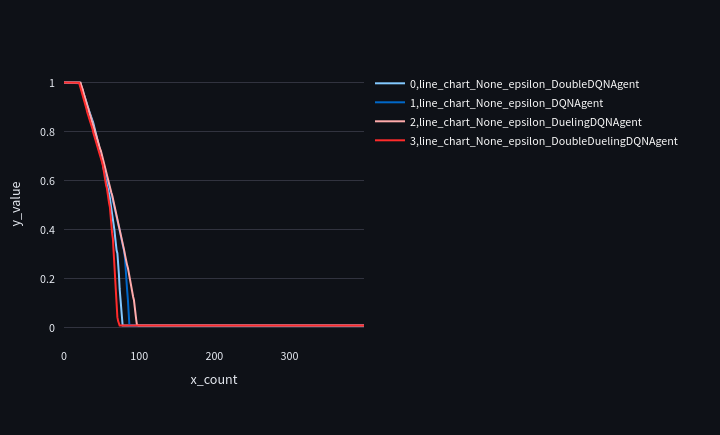

**Reward**

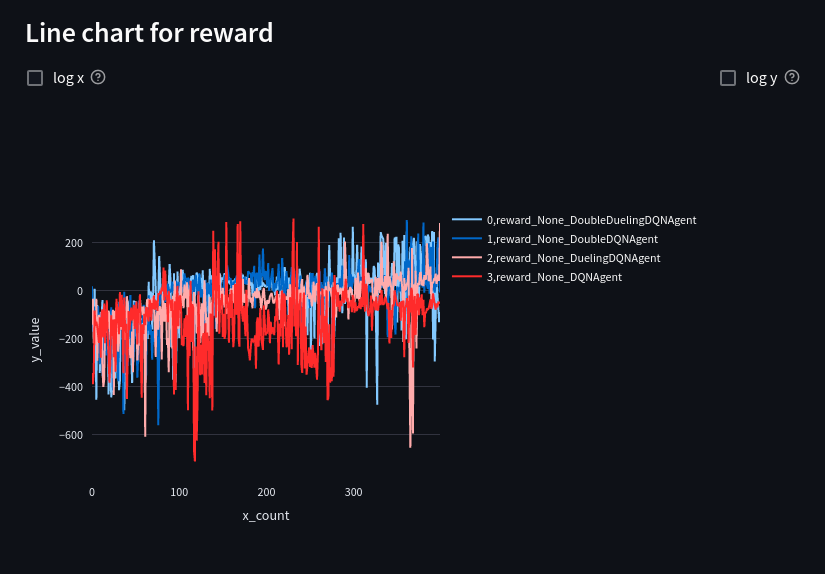

**Mean Reward (window size = 100)**

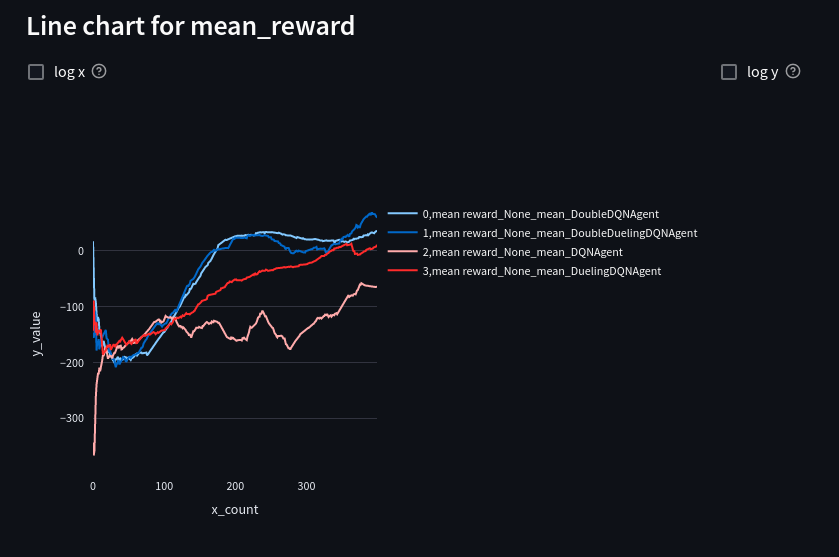

### Save Agent Networks

In [5]:
for agent in agents:
    agent.save_model()